In [1]:
import sys
# setting path
sys.path.append('../')

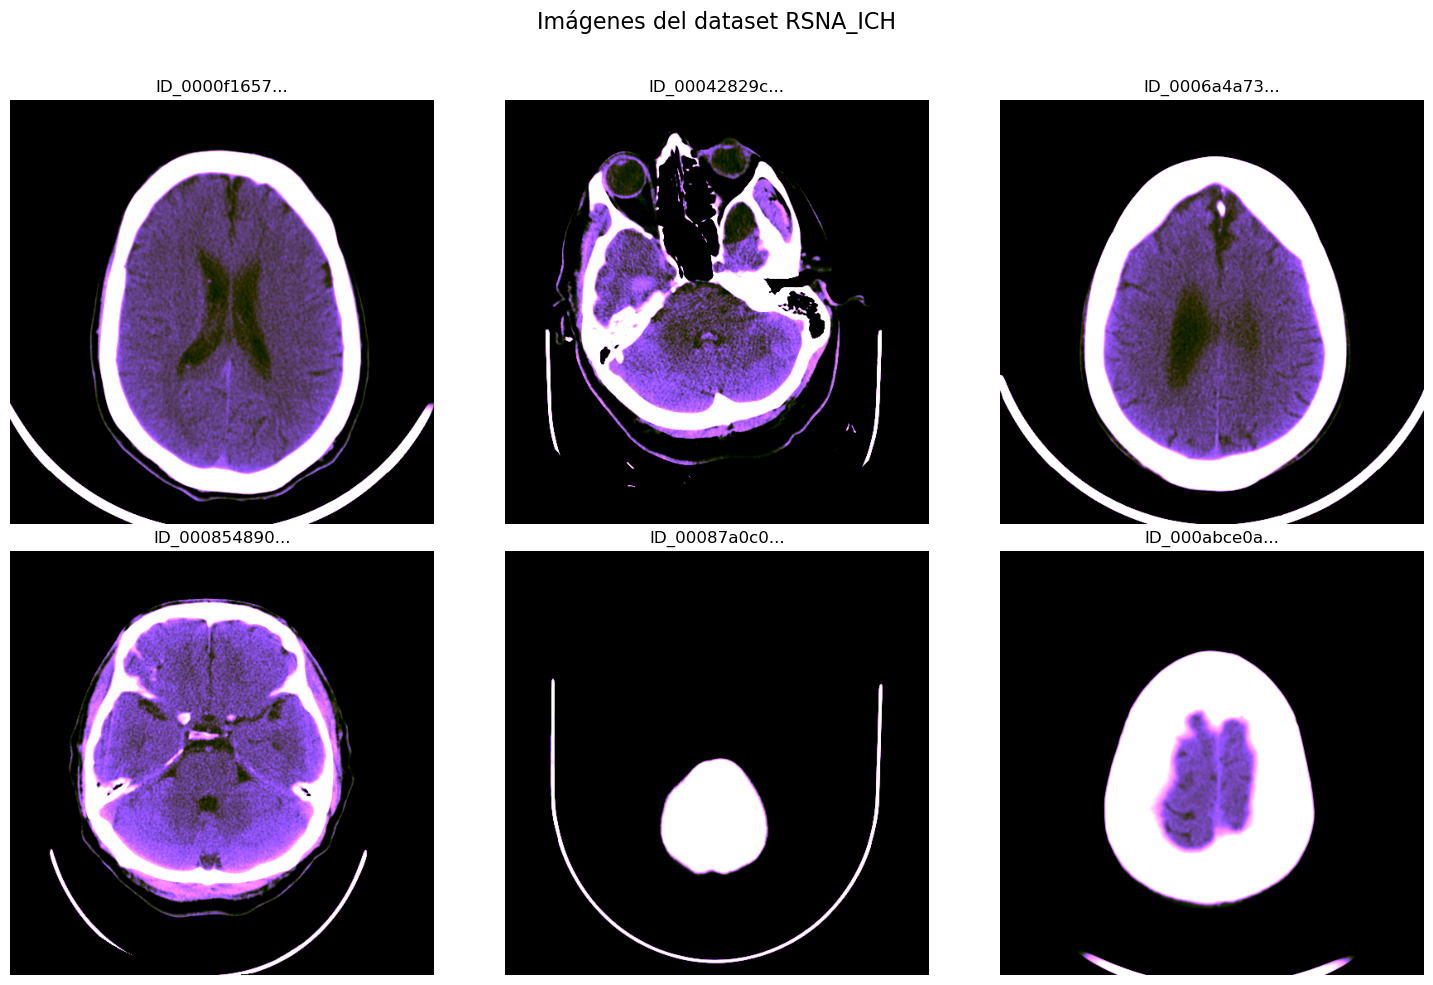

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Ruta absoluta al directorio de las imágenes
NPY_DIR = "/data/datasets/RSNA_ICH/original/"

# Listar los primeros 6 archivos .npy del directorio que comiencen por "ID_"
try:
    all_files = os.listdir(NPY_DIR)
except FileNotFoundError:
    print(f"ERROR: No se pudo encontrar el directorio en la ruta especificada.")
    print(f"Ruta intentada: {os.path.abspath(NPY_DIR)}")
    all_files = []

npy_files = sorted([f for f in all_files if f.startswith("ID_") and f.endswith(".npy")])[:6]

# Asegurarse de que hay al menos 6 archivos
if len(npy_files) < 6:
    print(f"Advertencia: Se encontraron solo {len(npy_files)} archivos de los 6 solicitados.")
    print("Se mostrarán los que se hayan encontrado.")

if npy_files:
    # Un aspect ratio más cuadrado (ej. 15 de ancho por 10 de alto) funciona mejor
    plt.figure(figsize=(15, 10))

    # Recorrer los archivos y mostrarlos
    for i, filename in enumerate(npy_files):
        img_path = os.path.join(NPY_DIR, filename)
        img_array = np.load(img_path)
        
        # --- CAMBIO 3: CREAR UNA CUADRÍCULA DE 2 FILAS Y 3 COLUMNAS ---
        # plt.subplot(filas, columnas, índice)
        plt.subplot(2, 3, i + 1)
        
        plt.imshow(img_array, cmap='gray')
        plt.axis('off')
        plt.title(filename[:12] + "...")

    # Título general de la figura
    plt.suptitle("Imágenes del dataset RSNA_ICH", fontsize=16)

    # --- CAMBIO 4: OPTIMIZAR EL ESPACIO EN BLANCO ---
    # tight_layout() ajusta automáticamente los subplots para que no haya solapamientos
    # y se reduzca el espacio en blanco.
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # El rect ajusta el espacio para el suptitle

    # Mostrar la figura
    plt.show()
else:
    print("No se encontraron imágenes para mostrar.")

/tmp/ipykernel_26260/2785459052.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Modelo cargado exitosamente desde: models/rsna/attention/seed0/model.pth
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Bag ID para el índice 10: ID_fe18e73b79

Visualizando la bolsa: ID_fe18e73b79
Predicción (probabilidad de ser positivo): 0.7480
Etiqueta real: 1.0


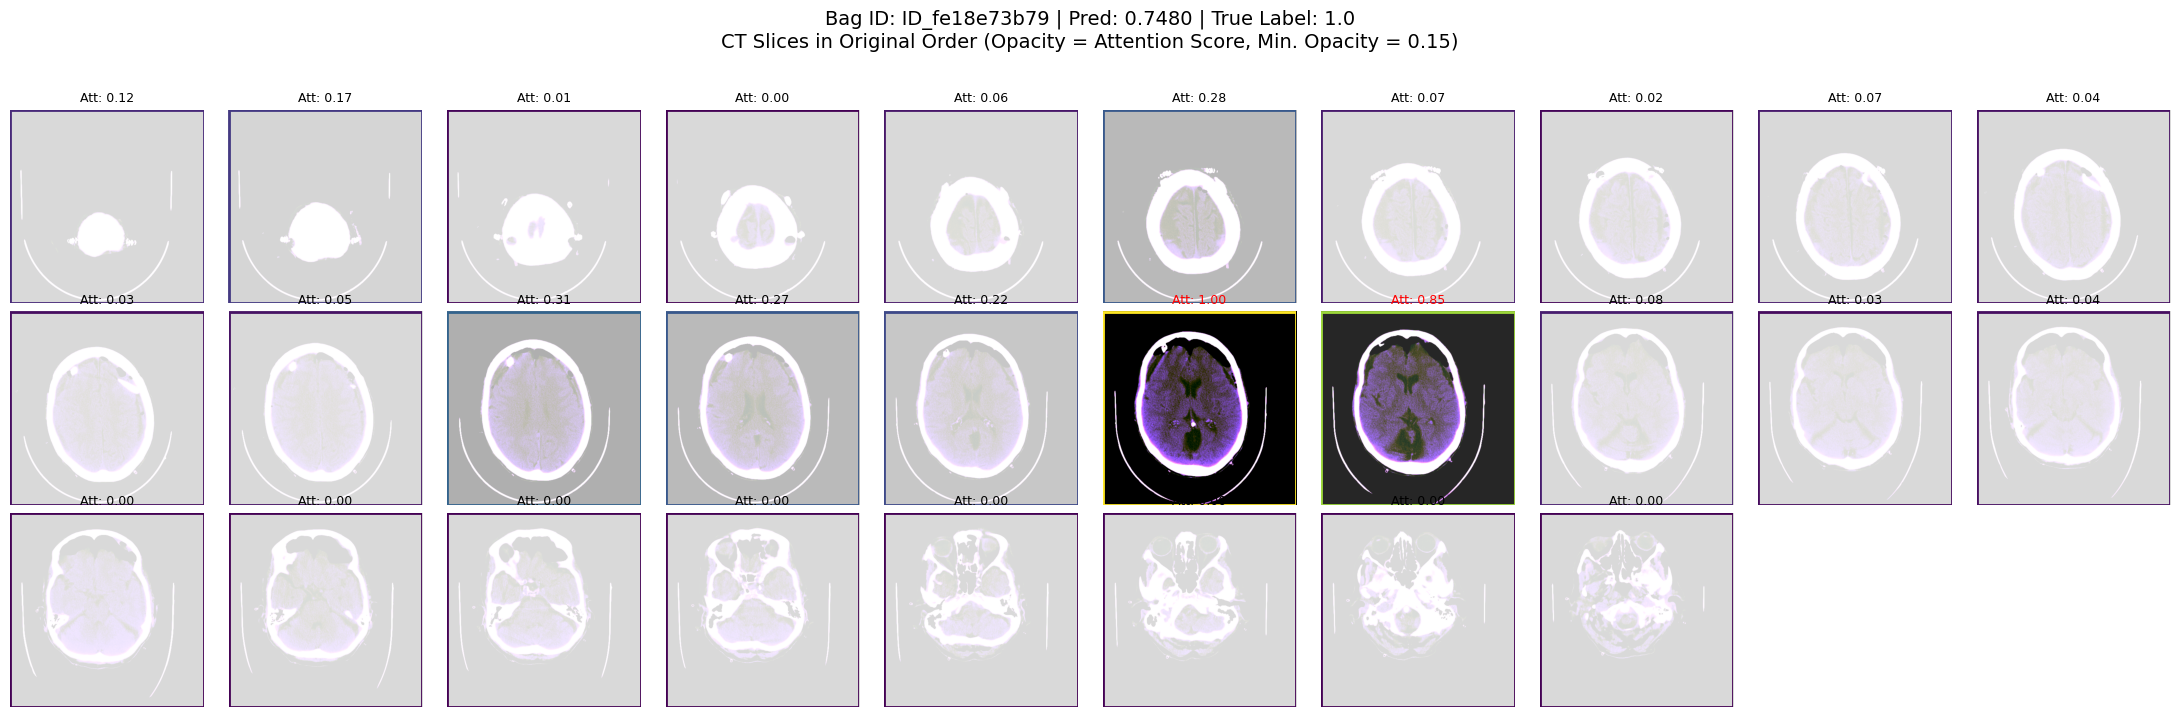

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from argparse import Namespace

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

try:
    from scripts.dataset_loader import load_dataset
    from scripts.MIL_utils import MIL_collate_fn
    from scripts.model import MILModel
    from scripts.plot_utils import normalize 
except (ImportError, ModuleNotFoundError) as e:
    print(f"Error importando módulos: {e}")
    print("Asegúrate de que la estructura de tu proyecto y el `sys.path` son correctos.")
    print(f"Current sys.path: {sys.path}")
    sys.exit()

# --- Custom Plotting Function for CT Slices with Alpha ---
def plot_ct_slices_and_heatmap(patches, attention_scores, bag_id, pred_prob, true_label, num_cols=10, min_alpha=0.15):
    """
    Visualiza todas las slices de CT de una bolsa, en su orden original,
    usando los pesos de atención para la transparencia.
    
    Args:
        patches (list of np.array): Lista de arrays NumPy, donde cada array es una slice de CT (2D o 3D con canales).
        attention_scores (np.array): Array 1D de pesos de atención, uno por cada parche (normalizado 0-1).
        bag_id (str): ID de la bolsa/paciente para el título.
        pred_prob (float): Probabilidad de predicción del modelo para la bolsa.
        true_label (int/float): Etiqueta real de la bolsa.
        num_cols (int): Número de columnas para organizar el grid de parches.
        min_alpha (float): Valor mínimo de transparencia (0.0 a 1.0).
                           Incluso si la atención es 0, la imagen tendrá al menos esta opacidad.
    """
    if len(patches) != len(attention_scores):
        print("Advertencia: El número de parches y pesos de atención no coincide. Ajustando al menor número.")
        min_len = min(len(patches), len(attention_scores))
        patches = patches[:min_len]
        attention_scores = attention_scores[:min_len]
        if min_len == 0:
            print("No hay parches o scores para visualizar.")
            return

    num_patches = len(patches)
    num_rows = (num_patches + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2.2, num_rows * 2.5))
    axes = axes.flatten()
    
    fig.suptitle(f"Bag ID: {bag_id} | Pred: {pred_prob:.4f} | True Label: {true_label}\n"
                 f"CT Slices in Original Order (Opacity = Attention Score, Min. Opacity = {min_alpha})", 
                 fontsize=14)

    for i in range(num_patches): # Iterar sobre el rango para mantener el orden original
        if i >= len(axes): # Evitar desbordamiento si hay más parches que subplots que celdas en el grid
            break
        
        ax = axes[i]
        current_patch = patches[i] # Acceder directamente al parche por su índice original
        current_attention = attention_scores[i] # Acceder directamente al score por su índice original

        # Aplicar el alpha mínimo para asegurar visibilidad
        display_alpha = max(current_attention, min_alpha)
        
        if current_patch.ndim == 3 and current_patch.shape[-1] == 3:
            ax.imshow(current_patch, alpha=display_alpha) 
        elif current_patch.ndim == 2:
            ax.imshow(current_patch, cmap='gray', alpha=display_alpha)
        elif current_patch.ndim == 3 and current_patch.shape[-1] == 1:
             ax.imshow(current_patch.squeeze(axis=-1), cmap='gray', alpha=display_alpha)
        else:
            print(f"Advertencia: El parche en el índice {i} tiene una forma no soportada para imshow: {current_patch.shape}. Saltando.")
            ax.set_title(f"Unsupported Img\nAtt: {current_attention:.2f}", fontsize=8)
            ax.axis('off')
            continue

        ax.set_title(f"Att: {current_attention:.2f}", fontsize=9, 
                     color='red' if current_attention > 0.7 else ('orange' if current_attention > 0.4 else 'black'))
        ax.axis('off')

        # El color del borde sigue reflejando el valor REAL de atención
        rect = plt.Rectangle((0, 0), current_patch.shape[1]-1, current_patch.shape[0]-1, 
                             linewidth=2, edgecolor=plt.cm.viridis(current_attention), facecolor='none', alpha=1.0)
        ax.add_patch(rect)

    # Ocultar los ejes no utilizados (si el número total de parches no llena el grid completo)
    for i in range(num_patches, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- FIN DE LA FUNCIÓN DE PLOTEO CUSTOM ---


# --- PARÁMETROS DE VISUALIZACIÓN ---
# **Asegúrate de que MODEL_PATH coincide con el modelo que quieres visualizar.**
MODEL_PATH = "models/rsna/attention/seed0/model.pth" 
ORIGINAL_DATA_DIR = "/data/datasets/RSNA_ICH/original/"
BAG_INDEX_TO_VISUALIZE = 10 

config_dict = {
    "dataset_name": "rsna", # Carga las imágenes originales para VISUALIZACIÓN
    "val_prop": 0.15,
    "seed": 0, # <-- Asegúrate de que este seed coincide con el del modelo cargado
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
}
config = Namespace(**config_dict)

INPUT_FEATURE_DIM = 512 
FEATURE_DIM = 128

# --- 1. CARGAR MODELO Y DATASET ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MILModel(
    pooling_type='attention',
    input_feature_dim=INPUT_FEATURE_DIM,
    feature_dim=FEATURE_DIM
)

try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()
    print(f"Modelo cargado exitosamente desde: {MODEL_PATH}")
except FileNotFoundError:
    print(f"ERROR: No se encontró el archivo del modelo en la ruta especificada: {MODEL_PATH}")
    print("Por favor, verifica que la ruta sea correcta y que el modelo haya sido entrenado y guardado.")
    sys.exit()
except Exception as e:
    print(f"ERROR al cargar el estado del modelo: {e}")
    sys.exit()

# --- CARGA DE DATASETS SEPARADOS PARA FEATURES Y IMÁGENES ---
config_features = Namespace(**{
    "dataset_name": "rsna-features_resnet18", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_features = load_dataset(config=config_features, mode="test")

config_images = Namespace(**{
    "dataset_name": "rsna", 
    "val_prop": 0.15, "seed": config.seed, "use_inst_distances": False, "adj_mat_mode": "relative"
})
test_dataset_images = load_dataset(config=config_images, mode="test")

if BAG_INDEX_TO_VISUALIZE >= len(test_dataset_features) or BAG_INDEX_TO_VISUALIZE >= len(test_dataset_images):
    print(f"Error: BAG_INDEX_TO_VISUALIZE ({BAG_INDEX_TO_VISUALIZE}) está fuera de rango para uno de los datasets.")
    sys.exit()

sample_features = test_dataset_features[BAG_INDEX_TO_VISUALIZE]
bag_features_for_model = sample_features[0] 
bag_label = sample_features[1] 

try:
    bag_id = test_dataset_images.bag_names[BAG_INDEX_TO_VISUALIZE]
    print(f"Bag ID para el índice {BAG_INDEX_TO_VISUALIZE}: {bag_id}")
except AttributeError:
    print("Error: El atributo 'bag_names' no se encontró en el dataset de IMÁGENES. Revisa `RSNADataset.py`.")
    sys.exit()
except IndexError:
    print(f"Error: El índice {BAG_INDEX_TO_VISUALIZE} está fuera de rango para `test_dataset_images.bag_names`.")
    sys.exit()

instance_paths_for_images = []
try:
    if hasattr(test_dataset_images, 'data_dict') and bag_id in test_dataset_images.data_dict:
        instance_paths_for_images = test_dataset_images.data_dict[bag_id]['inst_paths']
    else:
        raise AttributeError("El dataset de IMÁGENES no tiene el atributo 'data_dict' o el 'bag_id' no es una clave válida.")
except (AttributeError, KeyError) as e:
    print(f"Error al obtener las rutas de las IMÁGENES para el bag_id '{bag_id}': {e}")
    print("Asegúrate de que RSNADataset.py inicializa 'data_dict' y lo usa correctamente para 'inst_paths' cuando carga imágenes.")
    sys.exit()


# --- 2. OBTENER PESOS DE ATENCIÓN (USANDO FEATURES) ---
with torch.no_grad():
    bag_tensor = bag_features_for_model.unsqueeze(0).to(device) 
    prediction, attention_weights = model(bag_tensor)
    attention_weights = attention_weights.squeeze(0).cpu().numpy()
    prediction_prob = torch.sigmoid(prediction).item()

# --- 3. CARGAR IMÁGENES ORIGINALES DE LOS PARCHES (PARA VISUALIZACIÓN) ---
patches_image_data = [] 
if instance_paths_for_images: 
    for p_path in instance_paths_for_images:
        full_path = p_path 
        
        if os.path.exists(full_path):
            try:
                img_data = np.load(full_path)
                
                if img_data.ndim == 2 or (img_data.ndim == 3 and img_data.shape[-1] in [3, 4]):
                    patches_image_data.append(img_data)
                elif img_data.ndim == 3 and img_data.shape[-1] == 1:
                    patches_image_data.append(img_data.squeeze(axis=-1))
                else:
                    print(f"Advertencia: El archivo {full_path} no es una imagen 2D o RGB/RGBA. Shape: {img_data.shape}. Saltando.")

            except Exception as e:
                print(f"Advertencia: Error al cargar o procesar el archivo {full_path}: {e}")
        else:
            print(f"Advertencia: No se encontró el parche de imagen en la ruta: {full_path}")

if not patches_image_data:
    print("Error: No se pudieron cargar parches de IMAGEN para la visualización. Verifica las rutas y los archivos .npy.")
    sys.exit()
else:
    # --- 4. VISUALIZACIÓN ---
    print(f"\nVisualizando la bolsa: {bag_id}")
    print(f"Predicción (probabilidad de ser positivo): {prediction_prob:.4f}")
    print(f"Etiqueta real: {bag_label.item()}") 

    normalized_attention = normalize(attention_weights)
    
    plot_ct_slices_and_heatmap(
        patches=patches_image_data, 
        attention_scores=normalized_attention,
        bag_id=bag_id,
        pred_prob=prediction_prob,
        true_label=bag_label.item()
    )